Best SVM Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Accuracy: 0.99
Testing Accuracy: 0.91
Real Testing Accuracy: 0.42


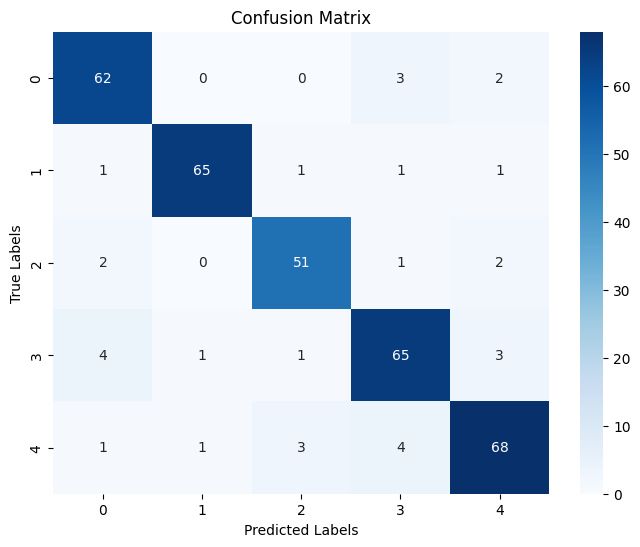

False Negative Rate for Class 0: 0.07
False Negative Rate for Class 1: 0.06
False Negative Rate for Class 2: 0.09
False Negative Rate for Class 3: 0.12
False Negative Rate for Class 4: 0.12

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        67
           1       0.97      0.94      0.96        69
           2       0.91      0.91      0.91        56
           3       0.88      0.88      0.88        74
           4       0.89      0.88      0.89        77

    accuracy                           0.91       343
   macro avg       0.91      0.91      0.91       343
weighted avg       0.91      0.91      0.91       343



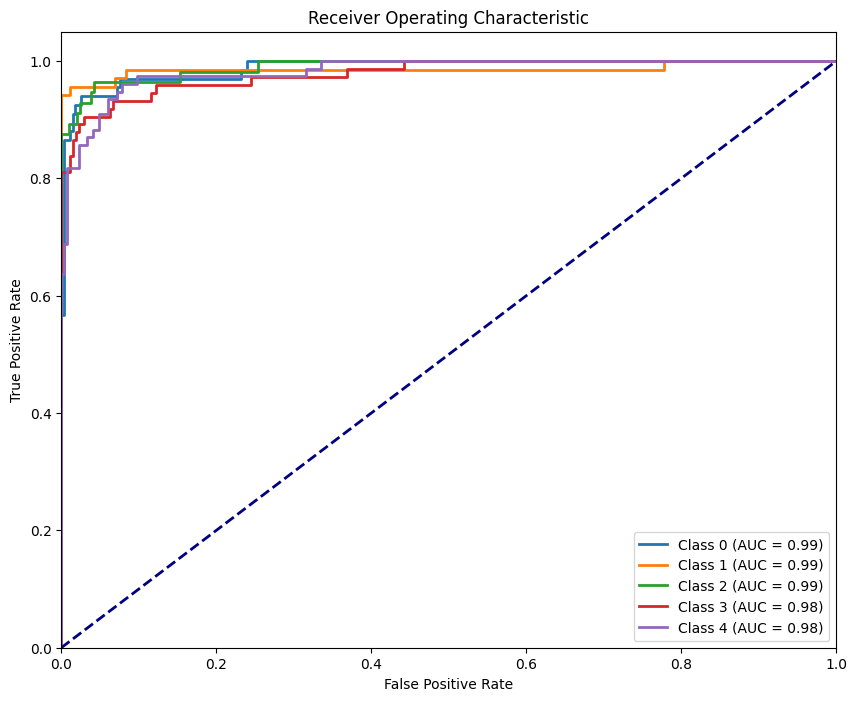

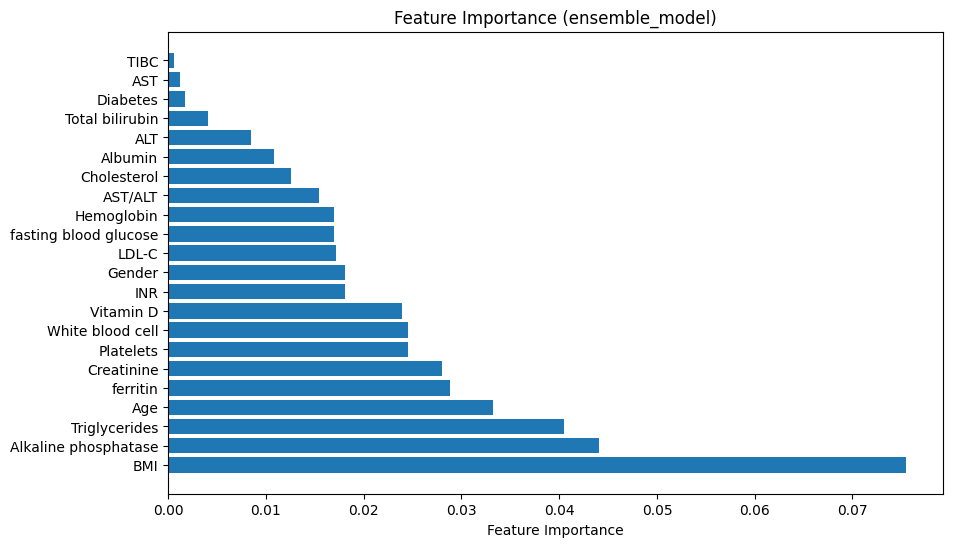

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Load training dataset
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_data_1.xlsx')
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)

# Splitting features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_combined = scaler.transform(X_test_combined)

# Hyperparameter tuning for SVM
param_grid_svm = {
    'C': [0.01, 0.1],
    'gamma': [0.1, 1],
    'kernel': ['rbf']
}

grid_svm = GridSearchCV(SVC(probability=True, class_weight='balanced'), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

# Best SVM model
svm_model = grid_svm.best_estimator_
print("Best SVM Parameters:", grid_svm.best_params_)

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Best RF model
rf_model = grid_rf.best_estimator_
print("Best RF Parameters:", grid_rf.best_params_)

# Ensemble model using Voting Classifier
ensemble_model = VotingClassifier(estimators=[('svm', svm_model), ('rf', rf_model)], voting='soft')
ensemble_model.fit(X_train, y_train)

# Check accuracy on test set
train_acc = ensemble_model.score(X_train, y_train)
test_acc = ensemble_model.score(X_test_combined, y_test_combined)
real_test_acc = ensemble_model.score(test_data_from_file.drop('steato score', axis=1), test_data_from_file['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"Real Testing Accuracy: {real_test_acc:.2f}")


# Evaluation on combined test data
y_test_pred_combined = ensemble_model.predict(X_test_combined)
y_test_prob_combined = ensemble_model.predict_proba(X_test_combined)

# Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

cm_combined = confusion_matrix(y_test_combined, y_test_pred_combined)
classes = np.unique(y_test_combined)
plot_confusion_matrix(cm_combined, classes)

# False Negative Rate for each class
fn_rate_per_class = []
for i in range(len(cm_combined)):
    FN = sum(cm_combined[i, :]) - cm_combined[i, i]
    TP = cm_combined[i, i]
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    fn_rate_per_class.append(FNR)

for i, fnr in enumerate(fn_rate_per_class):
    print(f"False Negative Rate for Class {classes[i]}: {fnr:.2f}")

# Classification Report
report = classification_report(y_test_combined, y_test_pred_combined, target_names=classes.astype(str))
print("\nClassification Report:\n", report)

# ROC Curve
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Permutation Importance (Ensemble Model)
results = permutation_importance(ensemble_model, X_test_combined, y_test_combined, scoring='accuracy', n_repeats=10, random_state=42)
importance_scores = results.importances_mean
sorted_idx = np.argsort(importance_scores)[::-1]

# Plot the permutation importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importance_scores[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (ensemble_model)')
plt.show()



Top Features for Class 0 based on predict_proba:
Diabetes: 0.0003
TIBC: -0.0009
Creatinine: -0.0020
AST: -0.0029
Triglycerides: -0.0029
fasting blood glucose: -0.0032
Gender: -0.0032
Hemoglobin: -0.0035
Total bilirubin: -0.0035
ALT: -0.0067
White blood cell: -0.0070
Albumin: -0.0070
Cholesterol: -0.0090
Platelets: -0.0096
AST/ALT: -0.0105
Vitamin D: -0.0114
LDL-C: -0.0134
ferritin: -0.0140
Age: -0.0143
INR: -0.0157
BMI: -0.0277
Alkaline phosphatase: -0.0373


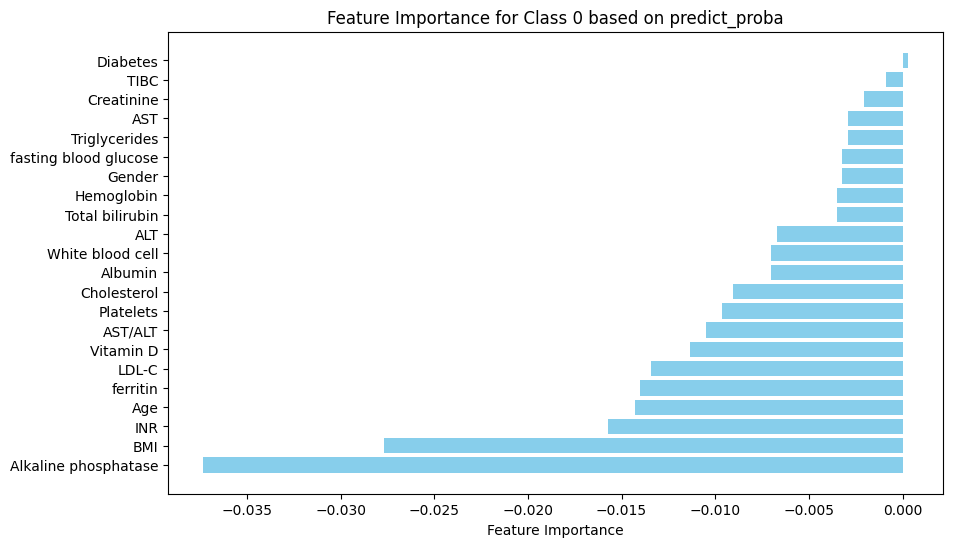


Top Features for Class 1 based on predict_proba:
Triglycerides: 0.0149
Alkaline phosphatase: 0.0137
INR: 0.0044
Creatinine: 0.0023
Diabetes: 0.0017
Vitamin D: 0.0006
fasting blood glucose: 0.0003
TIBC: -0.0003
Gender: -0.0006
Albumin: -0.0015
Hemoglobin: -0.0020
Age: -0.0038
AST: -0.0041
Total bilirubin: -0.0041
ALT: -0.0047
AST/ALT: -0.0058
White blood cell: -0.0067
Platelets: -0.0079
Cholesterol: -0.0082
ferritin: -0.0096
BMI: -0.0111
LDL-C: -0.0125


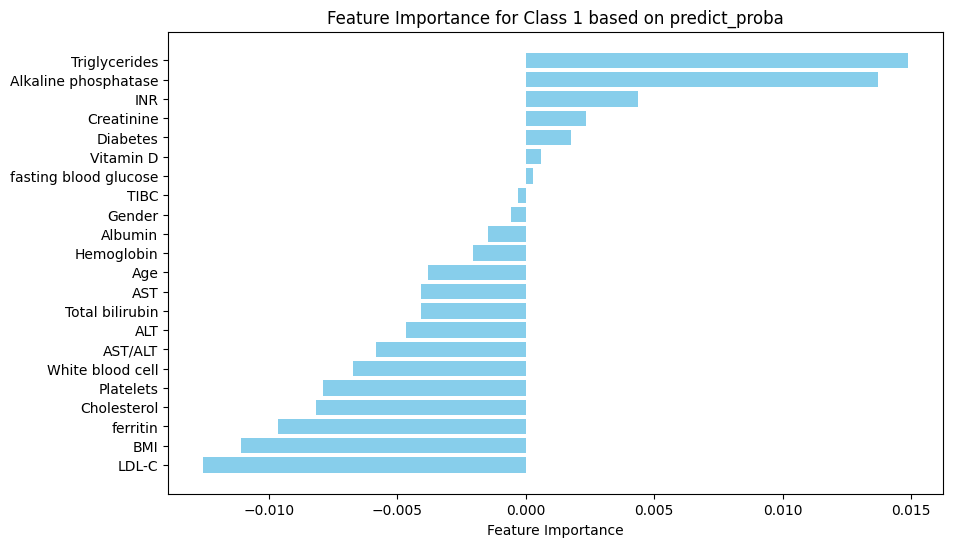


Top Features for Class 2 based on predict_proba:
Triglycerides: 0.0155
Creatinine: 0.0041
Diabetes: 0.0020
Gender: 0.0017
Age: 0.0017
fasting blood glucose: 0.0003
TIBC: -0.0006
Hemoglobin: -0.0009
ALT: -0.0026
Albumin: -0.0029
Total bilirubin: -0.0035
AST: -0.0041
Cholesterol: -0.0052
Vitamin D: -0.0052
White blood cell: -0.0058
LDL-C: -0.0064
Platelets: -0.0067
AST/ALT: -0.0082
BMI: -0.0082
ferritin: -0.0096
INR: -0.0122
Alkaline phosphatase: -0.0327


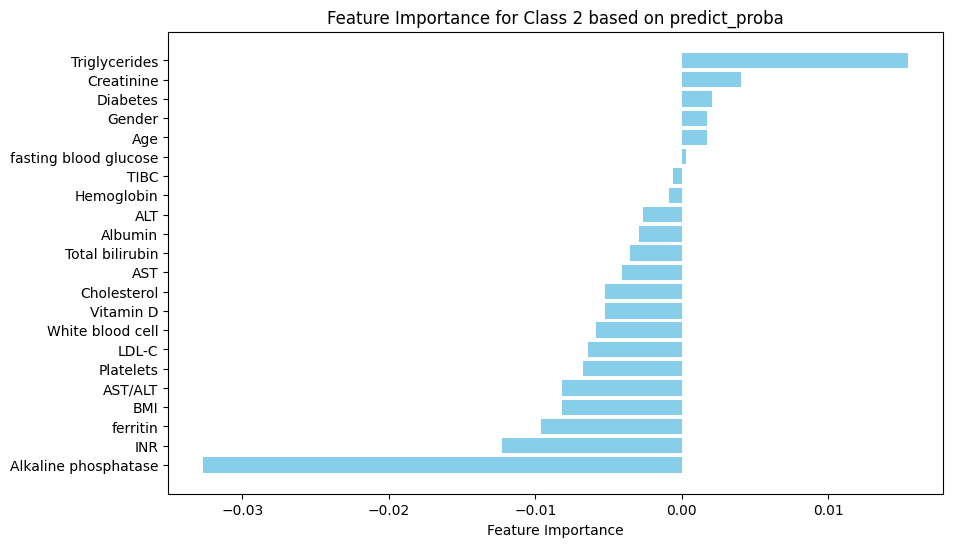


Top Features for Class 3 based on predict_proba:
Triglycerides: 0.0125
Diabetes: 0.0012
ferritin: 0.0003
TIBC: -0.0003
Creatinine: -0.0009
fasting blood glucose: -0.0015
Gender: -0.0020
Age: -0.0023
Hemoglobin: -0.0032
AST: -0.0035
ALT: -0.0041
Total bilirubin: -0.0041
Vitamin D: -0.0044
Albumin: -0.0055
Platelets: -0.0058
White blood cell: -0.0061
BMI: -0.0076
Cholesterol: -0.0099
AST/ALT: -0.0105
INR: -0.0111
LDL-C: -0.0128
Alkaline phosphatase: -0.0338


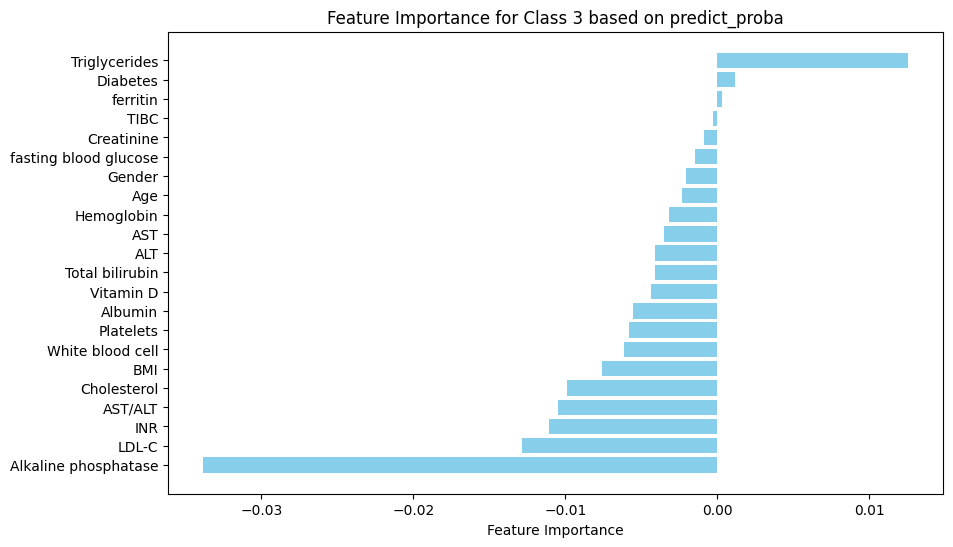


Top Features for Class 4 based on predict_proba:
Triglycerides: 0.0195
BMI: 0.0125
Creatinine: 0.0052
fasting blood glucose: 0.0052
AST/ALT: 0.0050
Hemoglobin: 0.0041
Age: 0.0038
Albumin: 0.0023
Diabetes: 0.0017
Gender: 0.0017
TIBC: -0.0003
White blood cell: -0.0006
ALT: -0.0006
Total bilirubin: -0.0009
Cholesterol: -0.0015
Vitamin D: -0.0015
AST: -0.0020
Platelets: -0.0035
ferritin: -0.0067
LDL-C: -0.0070
INR: -0.0090
Alkaline phosphatase: -0.0262


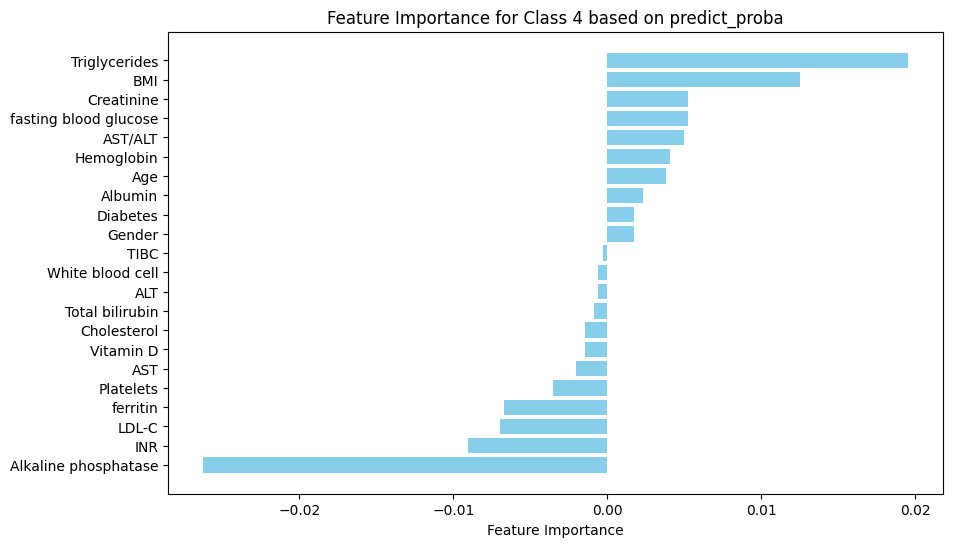

In [3]:
# Calculate feature importance for each class separately using predict_proba
feature_importances_per_class_proba = {}

# Loop over each class in the ensemble model
for class_index, cls in enumerate(ensemble_model.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba =ensemble_model.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba using permutation_importance
    importance_scores = permutation_importance(
        ensemble_model, X_test_combined, y_binary,
        scoring='accuracy', n_repeats=10, random_state=42
    ).importances_mean

    # Sort by importance (descending)
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Save results for later use
    feature_importances_per_class_proba[cls] = {
        "features": sorted_features,
        "scores": sorted_scores
    }

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
